In [84]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

# Import the geopandas and geoplot libraries
import geopandas as gpd
import folium

# Preprocessing
from sklearn.preprocessing import RobustScaler

# API access
import warnings
import requests # For downloading the website
import json

### Gathering the Data

In [85]:
# Reviewing the American Community Survey API - data profiles
profile = 'https://api.census.gov/data/2019/acs/acs5/profile'

#### Census - Baltimore

In [86]:
# ACCESS
# ============================
# Building the api GET request
# Including pertinent parameters on a county level basis for the country
maryland = "?get=DP05_0071PE,DP05_0077PE,DP05_0078PE,DP05_0079PE,DP05_0080PE&for=tract:*&in=state:24"
url = profile + maryland

In [87]:
# Checking the HTTP response code
response = requests.request('GET', url)
response.status_code

200

In [88]:
# PARSE
# ============================
# Parsing the JSON data into a python dictionary
maryland = response.json()

In [89]:
# STORE
# ============================
# Storing the data into a dataframe
md_acs = pd.DataFrame(maryland)

#### Census - Detroit

In [90]:
# ACCESS
# ============================
# Building the api GET request
# Including pertinent parameters on a county level basis for the country
michigan = "?get=DP05_0071PE,DP05_0077PE,DP05_0078PE,DP05_0079PE,DP05_0080PE&for=tract:*&in=state:26"
url = profile + michigan

In [91]:
# Checking the HTTP response code
response = requests.request('GET', url)
response.status_code

200

In [92]:
# PARSE
# ============================
# Parsing the JSON data into a python dictionary
michigan = response.json()

In [93]:
# STORE
# ============================
# Storing the data into a dataframe
mi_acs = pd.DataFrame(michigan)

#### Census - Los Angeles

In [94]:
# ACCESS
# ============================
# Building the api GET request
# Including pertinent parameters on a county level basis for the country
cali = "?get=DP05_0071PE,DP05_0077PE,DP05_0078PE,DP05_0079PE,DP05_0080PE&for=tract:*&in=state:06"
url = profile + cali

In [95]:
# Checking the HTTP response code
response = requests.request('GET', url)
response.status_code

200

In [96]:
# PARSE
# ============================
# Parsing the JSON data into a python dictionary
cali = response.json()

In [97]:
# STORE
# ============================
# Storing the data into a dataframe
ca_acs = pd.DataFrame(cali)

In [98]:
# Concating the cities datasets 
ACS = pd.concat([md_acs, mi_acs, ca_acs])

#### NTIA Indicators of Broadband Need - Census Tract

The [Indicators of Broadband Need] (https://broadbandusa.maps.arcgis.com/apps/webappviewer/index.html?id=e2b4907376b548f892672ef6afbc0da5) by the National Telecommunications and Information Administration had a couple of different datasets by area size. I am using their census tract level dataset.

Important note: There are high margins of errors at the census tract level!

In [99]:
# Reading in the NTIA dataset
internet = pd.read_csv('./Data/IBNTracts.csv', usecols =['Geographic Identifier - FIPS Code', 
                                                         'State', 'County', 
                                                         'Percent of Households with No Internet Access',
                                                         'Percent of Households with No Internet Access - Margin of Error', 
                                                         'Form 477 All Terrestrial Broadband: Max Advertised Consumer Download Speed (Mbps)', 
                                                         'Form 477 All Terrestrial Broadband: Max Advertised Consumer Upload Speed (Mbps)', 
                                                         'Ookla Median Download Speed (Mbps)', 
                                                         'Ookla Median Upload Speed (Mbps)', 
                                                         'Population 2019 (FCC Estimate)'])

In [100]:
# Renaming the columns
internet = internet.rename(columns ={'Geographic Identifier - FIPS Code' : 'FIPS', 'State' : 'state', 
                                     'County' : 'county', 
                                     'Percent of Households with No Internet Access' : 'no_internet',
                                     'Percent of Households with No Internet Access - Margin of Error' : 'MOE', 
                                     'Form 477 All Terrestrial Broadband: Max Advertised Consumer Download Speed (Mbps)' : 'max_speed', 
                                     'Form 477 All Terrestrial Broadband: Max Advertised Consumer Upload Speed (Mbps)' : 'min_speed', 
                                     'Ookla Median Download Speed (Mbps)' : 'median_download', 
                                     'Ookla Median Upload Speed (Mbps)' : 'median_upload', 
                                    'Population 2019 (FCC Estimate)' : 'population'})

#### Importing the shapefile

There is a fantastic project called [Not Even Past: Social Vulnerability and the Legacy of Redlining] (https://dsl.richmond.edu/socialvulnerability/) where reserachers from the University of Richmond, mapped out the redlining map made by the Home Owners Loan Corporation during the 1930s, onto the present day census tracts. I am using their shapefiles in order to get a redlining map overlay.

In [101]:
# Redlining map over census tracts
# Source: https://github.com/americanpanorama/Census_HOLC_Research
tracts = gpd.read_file('./Data/Tracts_2020_HOLC/Tracts_2020_HOLC.shp')

## Data Cleanup

#### ACS 

In [102]:
# Setting the first row as the column headers
ACS.columns = ACS.iloc[0]

# Dropping rows
ACS = ACS.drop(index = 0).reset_index(drop = True)

In [103]:
# Renaming columns
ACS = ACS.rename(columns = {'state' : 'state_id', 'county' : 'county_id'}) 

In [104]:
# Merging 'state', and 'county' together to get the full county number
ACS['FIPS'] = ACS['state_id'] + ACS['county_id'] + ACS['tract']

# # Dropping columns 
# ACS = ACS.drop(columns = ['state', 'county'])

In [105]:
# Changing the columns to a numeric value
ACS = ACS.apply(pd.to_numeric)

In [106]:
# Renaming the race/ethnicity column
ACS.rename(columns= {'DP05_0078PE' :'black', 
                             'DP05_0071PE' : 'hisp', 
                             'DP05_0080PE' : 'asian', 
                             'DP05_0079PE' : 'amerindian',
                             'DP05_0077PE' : 'white'}, inplace=True)

In [107]:
# List of columns that are precentages 
cols = ['black', 'hisp', 'asian', 'amerindian', 'white']

In [108]:
# Changing the percetage from a xx.xx format to .xxxx
for col_names in ACS:
    if (col_names in cols):
        ACS[col_names] = ACS[col_names] * 0.01

In [109]:
# Converting any areas with 0 racial and/or ethinic groups to a null value
for item in tqdm(range(len(ACS))): 
    for number in range(5):
        if ACS.iloc[item, number] == 0:
            ACS.iloc[item, number] = np.nan
        else: 
            continue

100%|███████████████████████████████████| 12276/12276 [00:03<00:00, 3696.71it/s]


#### NTIA

In [110]:
# Changing the percetage from a xx.xx format to .xxxx
internet['no_internet'] *= 0.01

# # Getting a population stat for people with no internet
# internet['no_internet'] *= internet['population']

#### Shapefile

So after exploring the shapefile I quickly realized that the researchers used an IPUMS crosswalk to generate the unique id (`GISJOIN`) for each tract. Luckily for me a quick search took me to this page: https://forum.ipums.org/t/gisjoin-field-for-tracts-understanding-extra-0s/3720/2 where I discovered that this `GISJOIN` id is essentially a FIPS code for a census tract with some additionally padded 0s.

In [111]:
# Creating a list of 'GISJOIN'
full_id = list(tracts['GISJOIN'])

In [112]:
# Creating an empty lists that will hold the FIPS code for the state, county and tract
state = []
county = []
tract = []

# Using a for loop to 
# a) covert the intergers into a string, 
# b) split it, 
# c) assign the first 2 values to the state list, 
# d) skipping a value and assigning the next two values to the county list and
# e) skipping a value and assigning the last 7 values to the tract list
# all while appending these values to a list 
for gisjoin in range(len(full_id)):
    state.append(str(full_id[gisjoin])[1:3]) # Leaving the values as strings so that way '00' doesn't become '0'
    county.append(str(full_id[gisjoin])[4:7])
    tract.append(str(full_id[gisjoin])[8:14])

In [113]:
# Creating new columns on the tracts dataframe for the FIPS code
tracts['state'] = state
tracts['county'] = county
tracts['tract'] = tract

In [114]:
# Creating a FIPS column 
tracts['FIPS'] = tracts['state'] + tracts['county'] + tracts['tract']

In [115]:
# Converting the 'FIPS' column into a numeric value
tracts['FIPS'] = pd.to_numeric(tracts['FIPS'])

In [116]:
# Dropping columns 
tracts = tracts.drop(['state', 'county', 'tract'], axis = 1)

## Merging the datasets

In [117]:
# Merging ACS with internet
cities = ACS.merge(internet, on = 'FIPS', how = 'inner')

# Merging the shapefile in
base = cities.merge(tracts, on = 'FIPS', how = 'inner')

## Exploring the datasets

In [118]:
# Determining the number of missing values per attribute
print(base.isna().sum())

hisp                263
white                59
black               259
amerindian         4487
asian              1157
state_id              0
county_id             0
tract                 0
FIPS                  0
state                 0
county                0
no_internet          57
MOE                  57
max_speed             0
min_speed             0
median_download       2
median_upload         2
population            0
GISJOIN               0
neighborho            0
SUM_Perc              0
FIRST_holc            0
MAX_state             0
MAX_city              0
Shape_Leng            0
Shape_Area            0
geometry              0
dtype: int64


In [119]:
# # Viewing the duplicated FIPS
# usa_internet[(usa_internet.isna().any(axis=1))]['id'].drop_duplicates()

In [120]:
# Dropping NA values 
base = base[~base['MOE'].isna()].reset_index(drop = True)

## Transforming the Dataset

### For the Maps

In [121]:
# Creating a new dataframe in order troubleshoot
cities_shp = base.copy()

In [122]:
# For loop that calculates the % of racial/ethnic residents in a census tract that do have internet access
# Also calculates how much of that population falls in the old HOLC boundaries
for race in ['black', 'hisp', 'asian', 'amerindian','white']:
    cities_shp[race] *= cities_shp['no_internet'] * cities_shp['SUM_Perc']

In [123]:
# Dropping columns 
cities_shp = cities_shp.drop(['SUM_Perc'], axis = 1)

In [124]:
# Converting the percentages back to a xx.xx
for ethnic in ['black', 'hisp', 'asian', 'amerindian', 'white']:
    cities_shp[ethnic] *= 100

In [125]:
#Rounding values
cities_shp[['population', 'no_internet', 'hisp', 'white', 'MOE',
            'black', 'amerindian', 'asian']]= round(cities_shp[['population', 'no_internet', 'hisp', 
                                                                'white', 'MOE','black', 'amerindian', 
                                                                'asian']], 5)

### For the Static Visualizations

In [126]:
# Creating new dataframe for the static visualizations
holc = base.copy()

In [127]:
# For loop that calculates the # of racial/ethnic residents that live in the old HOLC boundaries
for groups in ['black', 'hisp', 'asian', 'amerindian','white']:
    holc[groups + '_popn'] = holc['SUM_Perc'] * holc[groups] # Overall population %
    holc[groups + '_NI'] = holc['SUM_Perc'] * holc['population'] * holc[groups] * holc['no_internet'] # Population that doesn't have internet

In [128]:
# Filtering for only Baltimore, Los Angeles, and Detroit
holc = holc[(holc['MAX_city'] == 'Baltimore') | (holc['MAX_city'] == 'Los Angeles') | (holc['MAX_city'] == 'Detroit')]

In [129]:
# Splitting the dataset into 3 differnt maps depending on location
det_holc = holc[holc['MAX_city'] == 'Detroit'].reset_index(drop = True)
la_holc = holc[holc['MAX_city'] == 'Los Angeles'].reset_index(drop = True)
bal_holc = holc[holc['MAX_city'] == 'Baltimore'].reset_index(drop = True)

## Visualizations

### Maps

In [130]:
# Splitting the dataset into 3 differnt maps depending on location
detroit = cities_shp[cities_shp['MAX_city'] == 'Detroit'].reset_index(drop = True)
la = cities_shp[cities_shp['MAX_city'] == 'Los Angeles'].reset_index(drop = True)
baltimore = cities_shp[cities_shp['MAX_city'] == 'Baltimore'].reset_index(drop = True)

In [131]:
# Resaving the above datasets as a geopandas dataframe
detroit = gpd.GeoDataFrame(detroit)
la = gpd.GeoDataFrame(la)
baltimore = gpd.GeoDataFrame(baltimore)

#### Detroit

In [132]:
# Creating a Redlining map with digital redlining values included for Detroit
d = detroit.explore(column = 'FIRST_holc',
                    cmap = 'Paired',
                    tiles = 'cartodbdark_matter',
                    control = False,
                    popup = ('max_speed', 'min_speed', 'median_download', 'median_upload'),
                    tooltip = ['FIRST_holc', 'white', 'black', 'hisp', 'amerindian', 'asian',
                               'MOE', 'population'])

# Adding a different background map and allowing for layers
folium.TileLayer('cartodbpositron').add_to(d)
folium.LayerControl().add_to(d)

# Saving the map
d.save(outfile = 'detroit.html')

#### Los Angeles

In [133]:
# Creating a Redlining map with digital redlining values included for Los Angles
l = la.explore(column = 'FIRST_holc',
               cmap = 'Paired',
               tiles = 'cartodbdark_matter',
               control = False,
               popup = ('max_speed', 'min_speed', 'median_download', 'median_upload'),
               tooltip = ['FIRST_holc', 'white', 'black', 'hisp', 'amerindian', 'asian',
                          'MOE', 'population'])

# Adding a different background map and allowing for layers
folium.TileLayer('cartodbpositron').add_to(l)
folium.LayerControl().add_to(l)

# Saving the map
l.save(outfile = 'la.html')

#### Baltimore

In [134]:
# Creating a Redlining map with digital redlining values included for Baltimore
b = baltimore.explore(column = 'FIRST_holc',
                      cmap = 'Paired',
                      tiles = 'cartodbdark_matter',
                      control = False,
                      popup = ('max_speed', 'min_speed', 'median_download', 'median_upload'),
                      tooltip = ['FIRST_holc', 'white', 'black', 'hisp', 'amerindian', 'asian',
                                 'MOE', 'population'])

# Adding a different background map and allowing for layers
folium.TileLayer('cartodbpositron').add_to(b)
folium.LayerControl().add_to(b)

# Saving the map
b.save(outfile = 'baltimore.html')

### Static Visualizations

#### Population

In [135]:
# # Creating a dictionary where the keys are each individual city as indicated by a number and the values are their melted dataframes
# popn_dict = {}
# df_list = [det_holc, la_holc, bal_holc]

# for popn in range(3):
#     gp = df_list[popn].groupby(['FIRST_holc'])[['hisp_popn', 'white_popn', 
#                                                 'black_popn', 'amerindian_popn', 'asian_popn']].sum().reset_index()
#     gp = gp.rename({'hisp_popn' : 'hisp', 'white_popn' : 'white', 'black_popn' : 'black', 
#                     'amerindian_popn' : 'amerindian', 'asian_popn' : 'asian'}, axis = 1)
# # Melting the dataframe to understand how many people in each racial/ethnic group still live in HOLC neighborhoods
#     popn_dict[str(popn) + '_melt'] = pd.melt(gp, id_vars = ['FIRST_holc'],  value_vars = ['white', 'black', 'hisp', 
#                                                                                           'amerindian', 'asian'])

In [136]:
# # Creating subplots where the scale is the same across the different cities 
# f, axes = plt.subplots(1, 3, figsize=(20, 5), sharey = 'row')

# for i, (key, item) in enumerate(popn_dict.items()):
#     disp = sns.barplot(ax = axes[i], data = item, x = 'variable', y = 'value', hue = 'FIRST_holc')

# axes[0].set_title('Detroit')
# axes[1].set_title('Los Angeles')
# axes[2].set_title('Baltimore')

# plt.show()

In [137]:
# # Creating subplots where the scale is NOT the same across the different cities 
# f, axes = plt.subplots(1, 3, figsize=(20, 5))

# for i, (key, item) in enumerate(popn_dict.items()):
#     disp = sns.barplot(ax = axes[i], data = item, x = 'variable', y = 'value', hue = 'FIRST_holc')

# axes[0].set_title('Detroit')
# axes[1].set_title('Los Angeles')
# axes[2].set_title('Baltimore')

# plt.show()

#### No Internet - Population Distribution

In [138]:
# Creating a dictionary where the keys are each individual city as indicated by a number and the values are their melted dataframes
NI_dict = {}
df_list = [det_holc, la_holc, bal_holc]

for access in range(3):
    gp = df_list[access].groupby(['FIRST_holc'])[['hisp_NI', 'white_NI', 'black_NI', 'amerindian_NI', 'asian_NI']].sum().reset_index()
    gp = gp.rename({'hisp_NI' : 'hisp', 'white_NI' : 'white', 'black_NI' : 'black', 
                    'amerindian_NI' : 'amerindian', 'asian_NI' : 'asian'}, axis = 1)
# Melting the dataframe to understand how many people in each racial/ethnic group who don't have internet still live in HOLC neighborhoods
    NI_dict[str(access) + '_melt'] = pd.melt(gp, id_vars = ['FIRST_holc'],  value_vars = ['white', 'black', 'hisp', 
                                                                                          'amerindian', 'asian'])

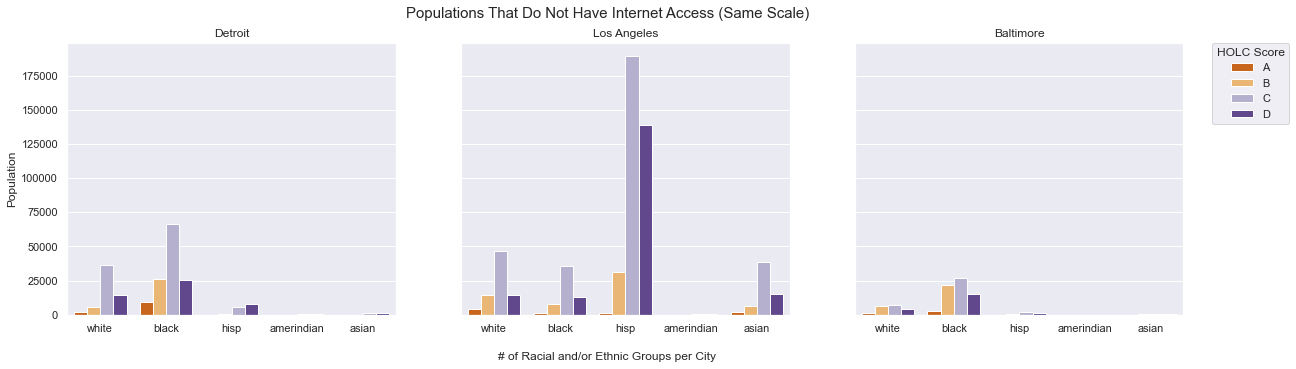

In [139]:
# Setting the theme
sns.set_theme()

# Creating subplots where the scale is the same across the different cities 
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharey = 'row')

for i, (key, item) in enumerate(NI_dict.items()):
    disp = sns.barplot(ax = axes[i], data = item, x = 'variable', y = 'value', hue = 'FIRST_holc', 
                       palette = ['#e66101','#fdb863','#b2abd2','#5e3c99'])
    axes[i].set_xlabel('') # Removing "Variable" for each plot
    axes[i].set_ylabel('Population')
    axes[i].get_legend().remove()
    if i!=0: # Removing "value" for each plot except for the very first plot
        axes[i].set_ylabel('')

# Setting the title of the subplot    
axes[0].set_title('Detroit')
axes[1].set_title('Los Angeles')
axes[2].set_title('Baltimore')

# Renaming the x-axis
f.text(0.5, -0, '# of Racial and/or Ethnic Groups per City', ha='center')

# Setting the title of the figure
f.suptitle('Populations That Do Not Have Internet Access (Same Scale)', ha = 'center', size = 15)

# Moving the legend to outside the graphs
handles, labels = axes[0].get_legend_handles_labels()
f.legend(handles, labels, bbox_to_anchor=(.92, 0.88), loc=2, borderaxespad=0., title = 'HOLC Score')

# Saving the graph
plt.savefig("cities_samescale.png", bbox_inches="tight")

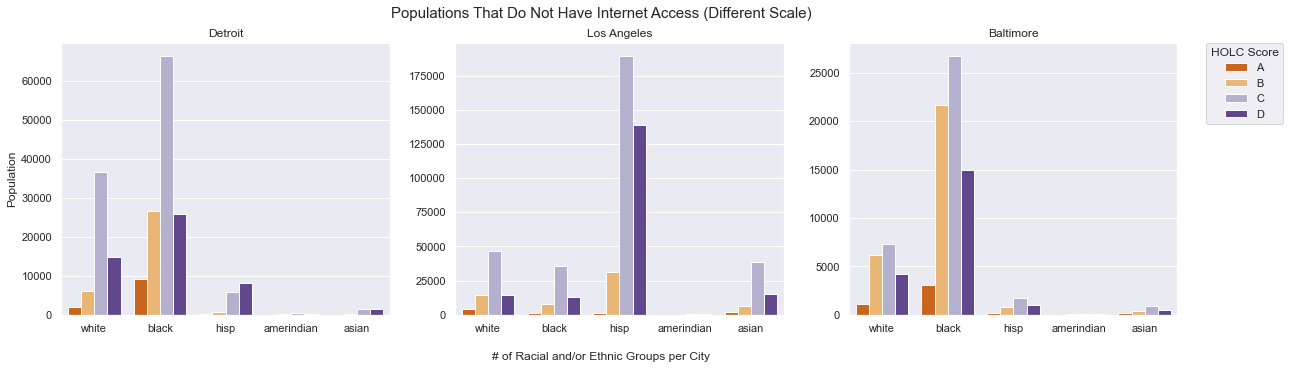

In [140]:
# Creating subplots where the scale is NOT the same across the different cities 
f, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, (key, item) in enumerate(NI_dict.items()):
    disp = sns.barplot(ax = axes[i], data = item, x = 'variable', y = 'value', hue = 'FIRST_holc', 
                       palette = ['#e66101','#fdb863','#b2abd2','#5e3c99'])
    axes[i].get_legend().remove()
    axes[i].set_xlabel('') # Removing "variable" for each plot
    axes[i].set_ylabel('Population')
    if i!=0: # Removing "value" for each plot except for the very first plot
        axes[i].set_ylabel('')

# Setting the title of subplot    
axes[0].set_title('Detroit')
axes[1].set_title('Los Angeles')
axes[2].set_title('Baltimore')

# Setting the title of the figure
f.suptitle('Populations That Do Not Have Internet Access (Different Scale)', ha = 'center', size = 15)

# Renaming the x-axis
f.text(0.5, -0, '# of Racial and/or Ethnic Groups per City', ha='center')

# Moving the legend to outside the graphs
handles, labels = axes[0].get_legend_handles_labels()
f.legend(handles, labels, bbox_to_anchor=(.92, 0.88), loc=2, borderaxespad=0., title = 'HOLC Score')

# Saving the graph
plt.savefig("cities_diffscale.png", bbox_inches="tight")

#### Median Download by City & HOLC

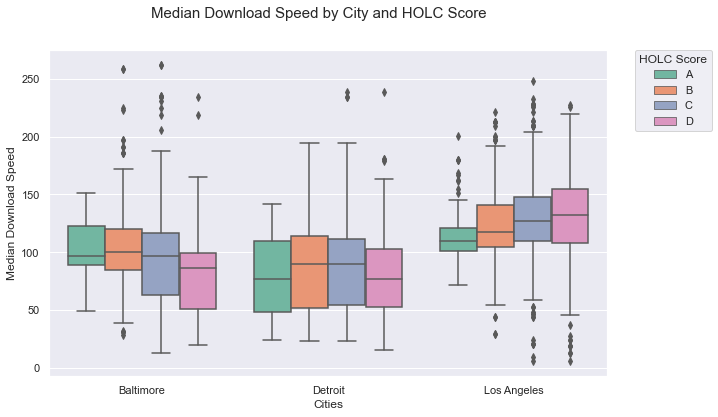

In [142]:
# Creating subplots where the scale is NOT the same across the different cities 
f = plt.figure(figsize=(10, 6))

# Creating a boxplot comparing the median download speed by city and HOLC
sns.boxplot(data = holc, x = 'MAX_city', y = 'median_download', hue = 'FIRST_holc', 
            hue_order = ['A', 'B', 'C', 'D'], palette = 'Set2')

# Renaming the x-axis
plt.xlabel('Cities')

# Renmaing the y-axis
plt.ylabel('Median Download Speed')

# Setting the title of the figure
f.suptitle('Median Download Speed by City and HOLC Score', ha = 'center', size = 15)

# Putting the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = 'HOLC Score')

# Saving the graph
plt.savefig("median_download.png", bbox_inches="tight")

In [143]:
# # # Creating subplots where the scale is NOT the same across the different cities 
# # f, axes = plt.subplots(5, 4, figsize=(20, 5))

# sns.lmplot(data = holc, x = 'white', y = 'median_download', col = 'FIRST_holc', 
#            col_order = ['A', 'B', 'C', 'D'], hue = 'FIRST_holc' , row ='MAX_city')

In [144]:
# sns.lmplot(data = holc, x = 'black', y = 'median_download', col = 'FIRST_holc', 
#            col_order = ['A', 'B', 'C', 'D'], hue = 'FIRST_holc' , row ='MAX_city')

In [145]:
# sns.lmplot(data = holc, x = 'hisp', y = 'median_download', col = 'FIRST_holc', 
#            col_order = ['A', 'B', 'C', 'D'], hue = 'FIRST_holc' , row ='MAX_city')

In [146]:
# sns.lmplot(data = holc, x = 'amerindian', y = 'median_download', col = 'FIRST_holc', 
#            col_order = ['A', 'B', 'C', 'D'], hue = 'FIRST_holc' , row ='MAX_city')

In [147]:
# sns.lmplot(data = holc, x = 'asian', y = 'median_download', col = 'FIRST_holc', 
#            col_order = ['A', 'B', 'C', 'D'], hue = 'FIRST_holc' , row ='MAX_city')

In [906]:
# # Map with the racial groups as a layer

# m = detroit.explore(
# #                     legend_name = 'HOLC Grade',
#                     cmap = 'Accent',
# #                     style_kwds=dict(color="black"),
#                     tiles = 'cartodbdark_matter', 
#                     control = True,
#                     popup = ('max_speed', 'min_speed', 'median_download', 'median_upload'),
#                     tooltip = ['FIRST_holc', 'white', 'black', 'hisp', 'amerindian', 'asian', 
#                                'MOE', 'population'])

# detroit_D.explore(column = ('FIRST_holc'), m = m, name ='D', legend = False, color = 'Red',           
#                 popup = ('max_speed', 'min_speed', 'median_download', 'median_upload'),
#                 tooltip = ['FIRST_holc', 'white', 'black', 'hisp', 'amerindian', 'asian', 
#                            'MOE', 'population'], show = False)

# detroit.explore(column = 'black', m = m, name ='Black', legend = False, cmap = 'binary',                  
#                 popup = ('max_speed', 'min_speed', 'median_download', 'median_upload'),
#                 tooltip = ['FIRST_holc', 'white', 'black', 'hisp', 'amerindian', 'asian', 
#                            'MOE', 'population'], show = False)

# detroit.explore(column = 'hisp', m = m, name = 'Hispanic/Latinx', legend = False, cmap = 'binary',                
#                 popup = ('max_speed', 'min_speed', 'median_download', 'median_upload'),
#                 tooltip = ['FIRST_holc', 'white', 'black', 'hisp', 'amerindian', 'asian', 
#                            'MOE', 'population'], show = False)

# detroit.explore(column = 'asian', m = m, name = 'Asian', legend = False, cmap = 'binary',                  
#                 popup = ('max_speed', 'min_speed', 'median_download', 'median_upload'),
#                 tooltip = ['FIRST_holc', 'white', 'black', 'hisp', 'amerindian', 'asian', 
#                            'MOE', 'population'], show = False)

# detroit.explore(column = 'amerindian', m = m, name = 'American-Indian', legend = False, 
#                 cmap = 'binary',  
#                 popup = ('max_speed', 'min_speed', 'median_download', 'median_upload'),
#                 tooltip = ['FIRST_holc', 'white', 'black', 'hisp', 'amerindian', 'asian', 
#                            'MOE', 'population'], show = False)

# detroit.explore(column = 'white', m = m, name ='white', legend = False, cmap = 'binary',           
#                 popup = ('max_speed', 'min_speed', 'median_download', 'median_upload'),
#                 tooltip = ['FIRST_holc', 'white', 'black', 'hisp', 'amerindian', 'asian', 
#                            'MOE', 'population'], show = False)
	
# folium.TileLayer('cartodbpositron').add_to(m)
# folium.LayerControl().add_to(m)

# m

In [907]:
## An alternative code

# # m = detroit.explore(column = 'white_max', tiles = "CartoDB positron")
# # We create another map called sample_map2.
# sample_map2 = folium.Map(location=[42.331429, -83.045753], zoom_start=10, tiles = "CartoDB positron")

# detroit.explore(column = 'FIRST_holc',
# #                 m = m,
#                 color = ['#ffffb2','#fecc5c','#fd8d3c','#e31a1c'], 
#                 popup = ('max_speed', 'min_speed', 'median_download', 'median_upload'),
#                 tooltip = 'max_nointernet', 
#                 style_kwds=dict(color="black"), 
#                 tiles="CartoDB positron")


# # Add hover functionality.
# style_function = lambda x: {'fillColor': '#ffffff', 
#                             'color':'#000000', 
#                             'fillOpacity': 0.1, 
#                             'weight': 0.1}
# highlight_function = lambda x: {'fillColor': '#000000', 
#                                 'color':'#000000', 
#                                 'fillOpacity': 0.50, 
#                                 'weight': 0.1}

# NIL = folium.features.GeoJson(
#     data = detroit,
#     style_function=style_function, 
#     control=False,
#     highlight_function=highlight_function, 
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=['hisp_max','asian_max', 'black_max', 'amerindian_max'],
#         aliases=['hispanic','asian', 'black', 'american-indian'],
#         style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
#     )
# )

# sample_map2.add_child(NIL)
# sample_map2.keep_in_front(NIL)

# # folium.LayerControl().add_to(m)
# # folium.TileLayer('Stamen Toner', control=True).add_to(m)
# # folium.TileLayer('Stamen Toner').add_to(m)
# # folium.TileLayer('Stamen Water Color').add_to(m)
# # folium.TileLayer('cartodbpositron').add_to(m)
# # folium.TileLayer('cartodbdark_matter').add_to(m)
# folium.LayerControl().add_to(sample_map2)

# sample_map2